In [1]:
import tensorflow as tf  # 导入TF库
from tensorflow.keras import layers, optimizers, datasets, Sequential, metrics  # 导入TF子库
import os, glob
import random, csv
import matplotlib.pyplot as plt

2023-09-21 17:19:09.658525: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 创建图片路径和标签，并写入csv文件
def load_csv(root, filename, name2label):
    # root:数据集根目录
    # filename:csv文件名
    # name2label:类别名编码表
    if not os.path.exists(os.path.join(root, filename)):  # 如果不存在csv，则创建一个
        images = []  # 初始化存放图片路径的字符串数组
        for name in name2label.keys():  # 遍历所有子目录，获得所有图片的路径
            # glob文件名匹配模式，不用遍历整个目录判断而获得文件夹下所有同类文件
            # 只考虑后缀为png,jpg,jpeg的图片，比如：pokemon\\mewtwo\\00001.png
            images += glob.glob(os.path.join(root, name, '*.png'))
            images += glob.glob(os.path.join(root, name, '*.jpg'))
            images += glob.glob(os.path.join(root, name, '*.jpeg'))
        print(len(images), images)  # 打印出images的长度和所有图片路径名
        random.shuffle(images)  # 随机打乱存放顺序
        # 创建csv文件，并且写入图片路径和标签信息
        with open(os.path.join(root, filename), mode='w', newline='') as f:
            writer = csv.writer(f)
            for img in images:  # 遍历images中存放的每一个图片的路径，如pokemon\\mewtwo\\00001.png
                name = img.split(os.sep)[-2]  # 用\\分隔，取倒数第二项作为类名
                label = name2label[name]  # 找到类名键对应的值，作为标签
                writer.writerow([img, label])  # 写入csv文件，以逗号隔开，如：pokemon\\mewtwo\\00001.png, 2
            print('written into csv file:', filename)
    # 读csv文件
    images, labels = [], []  # 创建两个空数组，用来存放图片路径和标签
    with open(os.path.join(root, filename)) as f:
        reader = csv.reader(f)
        for row in reader:  # 逐行遍历csv文件
            img, label = row  # 每行信息包括图片路径和标签
            label = int(label)  # 强制类型转换为整型
            images.append(img)  # 插入到images数组的后面
            labels.append(label)
    assert len(images) == len(labels)  # 断言，判断images和labels的长度是否相同
    return images, labels

# 首先遍历pokemon根目录下的所有子目录。对每个子目录，用类别名作为编码表的key，编码表的长度作为类别的标签，存进name2label字典对象
def load_pokemon(root, mode='train'):
    # 创建数字编码表
    name2label = {}  # 创建一个空字典{key:value}，用来存放类别名和对应的标签
    for name in sorted(os.listdir(os.path.join(root))):  # 遍历根目录下的子目录，并排序
        if not os.path.isdir(os.path.join(root, name)):  # 如果不是文件夹，则跳过
            continue
        name2label[name] = len(name2label.keys())   # 给每个类别编码一个数字
    images, labels = load_csv(root, 'images.csv', name2label)  # 读取csv文件中已经写好的图片路径，和对应的标签
    # 将数据集按6：2：2的比例分成训练集、验证集、测试集
    if mode == 'train':  # 60%
        images = images[:int(0.6 * len(images))]
        labels = labels[:int(0.6 * len(labels))]
    elif mode == 'val':  # 20% = 60%->80%
        images = images[int(0.6 * len(images)):int(0.8 * len(images))]
        labels = labels[int(0.6 * len(labels)):int(0.8 * len(labels))]
    else:  # 20% = 80%->100%
        images = images[int(0.8 * len(images)):]
        labels = labels[int(0.8 * len(labels)):]
    return images, labels, name2label

In [3]:
img_mean = tf.constant([0.485, 0.456, 0.406])
img_std = tf.constant([0.229, 0.224, 0.225])

def normalize(x, mean=img_mean, std=img_std):
    x = (x - mean)/std
    return x

In [4]:
def preprocess(image_path, label):
    # x: 图片的路径，y：图片的数字编码
    x = tf.io.read_file(image_path)  # 读入图片
    x = tf.image.decode_jpeg(x, channels=3)  # 将原图解码为通道数为3的三维矩阵
    x = tf.image.resize(x, [244, 244])
    # 数据增强
    # x = tf.image.random_flip_up_down(x) # 上下翻转
    # x = tf.image.random_flip_left_right(x)  # 左右镜像
    x = tf.image.random_crop(x, [224, 224, 3])  # 裁剪
    x = tf.cast(x, dtype=tf.float32) / 255.  # 归一化
    x = normalize(x)
    y = tf.convert_to_tensor(label)  # 转换为张量
    return x, y

In [5]:

# 1.加载自定义数据集
images, labels, table = load_pokemon('../data/pokemon', 'train')
print('images', len(images), images)
print('labels', len(labels), labels)
print(table)
db = tf.data.Dataset.from_tensor_slices((images, labels))  # images: string path， labels: number
db = db.shuffle(1000).map(preprocess,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16).repeat(20)

images 699 ['../data/pokemon/charmander/00000162.jpg', '../data/pokemon/bulbasaur/00000220.png', '../data/pokemon/charmander/00000175.jpg', '../data/pokemon/pikachu/00000131.jpg', '../data/pokemon/pikachu/00000224.jpg', '../data/pokemon/bulbasaur/00000033.jpg', '../data/pokemon/squirtle/00000110.jpg', '../data/pokemon/mewtwo/00000072.png', '../data/pokemon/charmander/00000232.jpg', '../data/pokemon/bulbasaur/00000196.png', '../data/pokemon/mewtwo/00000135.jpg', '../data/pokemon/bulbasaur/00000122.jpg', '../data/pokemon/pikachu/00000137.jpg', '../data/pokemon/bulbasaur/00000002.png', '../data/pokemon/squirtle/00000065.png', '../data/pokemon/charmander/00000091.jpg', '../data/pokemon/charmander/00000176.png', '../data/pokemon/bulbasaur/00000040.jpg', '../data/pokemon/bulbasaur/00000217.jpg', '../data/pokemon/charmander/00000011.png', '../data/pokemon/bulbasaur/00000076.png', '../data/pokemon/pikachu/00000035.png', '../data/pokemon/mewtwo/00000031.png', '../data/pokemon/bulbasaur/00000047

In [6]:
# 2.网络搭建
network = Sequential([
    # 第一层
    layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    # 第二层
    layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    # 第三层
    layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    # 第四层
    layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    # 第五层
    layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'),
    # 第六层
    layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    # 第七层
    layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'),
    # 第八层
    layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Flatten(),  # 拉直 7*7*512
    # 第九层
    layers.Dense(1024, activation='relu'),
    layers.Dropout(rate=0.5),
    # 第十层
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.5),
    # 第十一层
    layers.Dense(5, activation='softmax')
])
network.build(input_shape=(None, 224, 224, 3))  # 设置输入格式
network.summary()  # 打印各层参数表

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       5

In [7]:
# 3.模型训练（计算梯度，迭代更新网络参数）
optimizer = optimizers.SGD(lr=0.01)  # 声明采用批量随机梯度下降方法，学习率=0.01
acc_meter = metrics.Accuracy()
x_step = []
y_accuracy = []
for step, (x, y) in enumerate(db):  # 一次输入batch组数据进行训练
    with tf.GradientTape() as tape:  # 构建梯度记录环境
        x = tf.reshape(x, (-1, 224, 224, 3))  # 将输入拉直，[b,28,28]->[b,784]
        out = network(x)  # 输出[b, 10]
        y_onehot = tf.one_hot(y, depth=5)  # one-hot编码
        loss = tf.square(out - y_onehot)
        loss = tf.reduce_sum(loss)/16  # 定义均方差损失函数，注意此处的32对应为batch的大小
        grads = tape.gradient(loss, network.trainable_variables)  # 计算网络中各个参数的梯度
        optimizer.apply_gradients(zip(grads, network.trainable_variables))  # 更新网络参数
        acc_meter.update_state(tf.argmax(out, axis=1), y)  # 比较预测值与标签，并计算精确度
    if step % 10 == 0:  # 每200个step，打印一次结果
        print('Step', step, ': Loss is: ', float(loss), ' Accuracy: ', acc_meter.result().numpy())
        x_step.append(step)
        y_accuracy.append(acc_meter.result().numpy())
        acc_meter.reset_states()

2023-09-21 17:22:20.653441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:22:20.653482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:22:20.784289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:22:21.192317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 0 : Loss is:  0.8004348874092102  Accuracy:  0.0625


2023-09-21 17:22:48.204806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:22:57.087425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:23:07.112135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:23:27.344292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 10 : Loss is:  0.7935020923614502  Accuracy:  0.24375


2023-09-21 17:24:04.228933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:24:04.268832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:24:13.325860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:24:23.307605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 17:25:01.483522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:25:01.522477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:25:01.522513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:25:12.058368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:25:20.999321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: 

Step 20 : Loss is:  0.7994827628135681  Accuracy:  0.2375


2023-09-21 17:25:44.660406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:25:54.397008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:26:27.216628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:26:43.376310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:26:54.320902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 30 : Loss is:  0.7922435402870178  Accuracy:  0.3375


2023-09-21 17:27:29.276023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:27:58.338580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:27:58.378495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:27:58.530368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:27:58.541183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:28:09.699595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:28:19.852114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:28:46.839298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 40 : Loss is:  0.7911276817321777  Accuracy:  0.36875


2023-09-21 17:29:15.251748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:29:15.770836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:29:40.584944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:30:08.073344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:30:19.049671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 50 : Loss is:  0.7914891839027405  Accuracy:  0.36774194


2023-09-21 17:30:33.970978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:30:34.038099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:31:05.323181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:31:14.424837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:31:14.703478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:31:24.372138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:31:51.085070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:31:51.136040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:31:59.417201: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 60 : Loss is:  0.7874504923820496  Accuracy:  0.375


2023-09-21 17:32:18.553434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:32:28.051873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:32:54.873930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles


Step 70 : Loss is:  0.7692474722862244  Accuracy:  0.33125


2023-09-21 17:33:54.013632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:34:24.357838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:34:59.030800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:34:59.096890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:34:59.313763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:35:10.652498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:35:10.667163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:35:10.667591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


Step 80 : Loss is:  0.7903891801834106  Accuracy:  0.35


2023-09-21 17:35:21.731051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:35:41.811962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:35:41.812081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:35:53.316136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:35:53.338129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:36:23.107637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:36:23.359110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:36:23.359144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:36:38.730882: W tensorflow/core/lib/png/png_io.cc:88] 

Step 90 : Loss is:  0.7885371446609497  Accuracy:  0.43870968


2023-09-21 17:36:58.900502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:38:06.912956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:38:06.941785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:38:07.088657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:38:19.120612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:38:19.158445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 100 : Loss is:  0.7656580209732056  Accuracy:  0.41875


2023-09-21 17:38:42.169293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:39:05.086566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:39:29.645150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 17:39:37.774478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:39:37.890419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:40:01.878232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 110 : Loss is:  0.7437610626220703  Accuracy:  0.40625


2023-09-21 17:40:31.939387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:40:46.236182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:40:46.302758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:41:15.566906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:41:30.411874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:41:30.586515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:41:30.586547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:42:14.194343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 120 : Loss is:  0.764148473739624  Accuracy:  0.43125


2023-09-21 17:42:59.056185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:43:13.994878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:43:58.190732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:44:12.554371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:44:26.364014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 130 : Loss is:  0.7213292121887207  Accuracy:  0.46875


2023-09-21 17:45:09.940559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:45:10.127546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:45:20.689019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:46:33.982928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 17:46:34.023669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:47:00.453947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:47:00.556838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:47:12.521891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 140 : Loss is:  0.7174002528190613  Accuracy:  0.5096774


2023-09-21 17:47:20.674017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:47:28.883496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:47:37.076274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:48:10.661027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:48:10.698727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:48:19.119530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:48:19.188000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:48:29.094112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 150 : Loss is:  0.683342695236206  Accuracy:  0.50625


2023-09-21 17:49:01.044163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:49:01.135061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:49:21.112362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:49:21.179911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:49:21.179955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:50:06.682782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:50:06.682811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:50:18.560405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 160 : Loss is:  0.5935643315315247  Accuracy:  0.51875


2023-09-21 17:50:47.450150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:50:55.600341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:51:03.609495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:51:19.779106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:51:28.525716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:51:59.916622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 170 : Loss is:  0.5229195356369019  Accuracy:  0.51875


2023-09-21 17:52:41.275548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:52:41.275590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:52:41.596734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:52:41.730119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:52:42.065539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:52:42.288361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:52:42.396516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:52:47.468658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:52:55.403616: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 180 : Loss is:  0.5859009623527527  Accuracy:  0.59354836


2023-09-21 17:53:49.556425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:54:10.002819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:54:10.120785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:54:22.945777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:54:36.248371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:54:36.484070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:55:06.931445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:55:18.170139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:55:18.242522: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 190 : Loss is:  0.47350677847862244  Accuracy:  0.60625


2023-09-21 17:56:29.931561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:56:56.475666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:57:06.027488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 200 : Loss is:  0.8102504014968872  Accuracy:  0.58125


2023-09-21 17:57:35.732554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:57:53.951114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:58:43.043641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 210 : Loss is:  0.5391436815261841  Accuracy:  0.68125


2023-09-21 17:59:07.818369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:59:07.870393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 17:59:15.979332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:59:24.243350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:59:47.222596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:59:47.222633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 18:00:29.582902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:00:29.691010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:00:29.979898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: 

Step 220 : Loss is:  0.5997034311294556  Accuracy:  0.61290324


2023-09-21 18:00:54.330337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:01:13.249072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:01:22.811011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:02:03.303337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 230 : Loss is:  0.44461584091186523  Accuracy:  0.63125


2023-09-21 18:03:26.149220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:03:26.245094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:03:35.303571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:03:35.415921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:03:43.445349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 240 : Loss is:  0.24151194095611572  Accuracy:  0.7875


2023-09-21 18:04:03.591890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:05:00.766507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 18:05:13.871273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:05:13.987351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:05:26.553311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:05:26.553360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 18:05:38.489729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:05:38.489767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 18:05:48.899206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning

Step 250 : Loss is:  0.25383442640304565  Accuracy:  0.725


2023-09-21 18:06:40.005320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:06:40.044378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:06:40.061718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:06:51.925133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:07:19.776708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:07:19.885343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:07:30.442591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 260 : Loss is:  0.3098158836364746  Accuracy:  0.75


2023-09-21 18:08:09.752266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:08:09.854407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:08:20.303512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:08:43.811400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:09:07.259674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:09:23.581371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:09:23.604361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 18:09:23.612102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 270 : Loss is:  0.8354442119598389  Accuracy:  0.7096774


2023-09-21 18:09:56.984387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:10:07.659813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:10:16.246280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:10:35.900383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:10:46.837804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 280 : Loss is:  0.43687260150909424  Accuracy:  0.69375


2023-09-21 18:11:21.021155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:11:29.821403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:11:29.870744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:12:08.486670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:12:27.469805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:12:44.679902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:12:44.681142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:12:44.765447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:13:14.116139: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 290 : Loss is:  0.20043085515499115  Accuracy:  0.79375


2023-09-21 18:13:34.545859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:14:14.254744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:15:03.786785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:15:03.786815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 18:15:03.907266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 300 : Loss is:  0.6858585476875305  Accuracy:  0.7625


2023-09-21 18:15:30.816306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:15:30.816342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 18:16:06.955791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:16:07.010721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:16:07.324307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:16:07.513094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:16:07.586478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:16:07.774531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 310 : Loss is:  0.341115802526474  Accuracy:  0.7870968


2023-09-21 18:18:03.551837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:18:20.857699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:18:20.963702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 320 : Loss is:  0.24576564133167267  Accuracy:  0.8125


2023-09-21 18:18:29.494896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:18:37.913656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:18:54.358711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:18:54.361806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 18:19:49.223810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:20:18.346816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 330 : Loss is:  0.3636777698993683  Accuracy:  0.81875


2023-09-21 18:20:33.268202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:21:00.805299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:21:59.049998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:21:59.168418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:22:13.609239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:22:13.701449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:22:13.701558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 18:22:13.748207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:22:42.706169: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 340 : Loss is:  0.23877757787704468  Accuracy:  0.75


2023-09-21 18:23:10.288857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:23:47.246463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:23:55.696838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:23:55.729576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:24:17.109259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 350 : Loss is:  0.17702555656433105  Accuracy:  0.83125


2023-09-21 18:24:54.775513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:24:54.835942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:24:55.254011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:24:55.610558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 18:25:16.721050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:25:30.942613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:25:31.006595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:25:43.276685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:25:43.276721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iC

Step 360 : Loss is:  0.07918599247932434  Accuracy:  0.83870965


2023-09-21 18:26:56.474228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:26:56.639386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:27:37.349780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:27:53.394979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 370 : Loss is:  0.22947970032691956  Accuracy:  0.83125


2023-09-21 18:28:31.377207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:28:53.138189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:28:53.253757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:28:53.253780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 18:29:12.817366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 380 : Loss is:  0.27582037448883057  Accuracy:  0.825


2023-09-21 18:29:40.193061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:29:40.251464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:30:25.462684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:30:45.787309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:30:56.284201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 390 : Loss is:  0.28893473744392395  Accuracy:  0.775


2023-09-21 18:31:14.436206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:31:51.818201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 18:31:52.078333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:31:57.756050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:31:57.756081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 18:32:25.802163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 400 : Loss is:  0.1573006510734558  Accuracy:  0.81935483


2023-09-21 18:33:00.312603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:33:10.498087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:33:27.370685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:33:35.535763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:33:35.611472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:33:52.050822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:34:12.026186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 410 : Loss is:  0.31162527203559875  Accuracy:  0.8375


2023-09-21 18:34:20.144829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:34:40.315320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:34:59.280638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:34:59.280668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 18:34:59.473385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:35:18.303557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:35:29.682335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:35:49.068513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:35:49.119869: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 420 : Loss is:  0.288594514131546  Accuracy:  0.83125


2023-09-21 18:36:36.709477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:36:36.839623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:36:54.277989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:36:54.283661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:37:03.108105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:37:19.328183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:37:19.438151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 430 : Loss is:  0.10175780951976776  Accuracy:  0.9125


2023-09-21 18:37:35.925162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:37:44.656735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:38:47.489259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:38:53.512430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:38:53.596628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 440 : Loss is:  0.365522563457489  Accuracy:  0.7612903


2023-09-21 18:39:21.266831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:39:21.357361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:39:39.249458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:39:39.254455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 18:39:39.289945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:39:47.674263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:40:03.983420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:40:12.298526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 450 : Loss is:  0.19223591685295105  Accuracy:  0.85625


2023-09-21 18:40:33.079333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:41:28.778119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:41:39.223412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:41:39.223669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:42:03.561104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 460 : Loss is:  0.3679215908050537  Accuracy:  0.85625


2023-09-21 18:42:14.948838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:42:24.792324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:42:25.045987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:42:35.222177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:42:35.396213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:42:54.012980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:42:54.013016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


Step 470 : Loss is:  0.21310141682624817  Accuracy:  0.8375


2023-09-21 18:43:51.148275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:44:00.324910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:44:00.332034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:44:19.923999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 18:44:30.737524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:44:58.730445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:45:17.426900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 480 : Loss is:  0.27754348516464233  Accuracy:  0.9


2023-09-21 18:45:47.329055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:45:47.463315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:45:47.603922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:45:47.690347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:46:12.660384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:46:22.237956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:46:22.238290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


Step 490 : Loss is:  0.2321360558271408  Accuracy:  0.8967742


2023-09-21 18:47:00.968118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:47:00.968147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 18:47:49.009251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:47:49.084253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:47:58.873629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:47:58.909330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:47:58.925289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:48:08.817659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:48:18.463954: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 500 : Loss is:  0.07034633308649063  Accuracy:  0.9125


2023-09-21 18:48:37.771400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:48:37.830686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:49:35.763107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:49:35.838601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:49:55.286477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles


Step 510 : Loss is:  0.22866535186767578  Accuracy:  0.8375


2023-09-21 18:50:42.521657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:50:52.293529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:51:01.774347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:51:21.387992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:51:21.691432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 520 : Loss is:  0.24824082851409912  Accuracy:  0.90625


2023-09-21 18:51:50.831284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:51:50.984720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:51:51.010364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:52:50.602287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:52:50.664768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:52:50.989056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:52:51.157395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:52:51.157427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 18:52:51.244944: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 530 : Loss is:  0.07802252471446991  Accuracy:  0.90967745


2023-09-21 18:53:27.408241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:53:27.511093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:54:06.350450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:54:45.213598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 540 : Loss is:  0.45827198028564453  Accuracy:  0.875


2023-09-21 18:55:05.289135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:55:05.400319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:55:35.386749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:55:44.914923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:55:54.607803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles


Step 550 : Loss is:  0.08225484192371368  Accuracy:  0.91875


2023-09-21 18:56:54.108029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:57:06.086450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:57:16.570874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:57:26.699682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:57:47.016467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:57:47.076677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:57:47.096847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:57:47.096879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 18:57:57.596475: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 560 : Loss is:  0.27262476086616516  Accuracy:  0.83125


2023-09-21 18:58:41.010354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:59:30.468615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 18:59:40.320243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 570 : Loss is:  0.03522438183426857  Accuracy:  0.9


2023-09-21 19:00:20.681905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:00:21.357171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:00:37.580720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:00:47.090262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:01:06.362223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:01:25.786923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:01:35.234438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:01:44.874315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 580 : Loss is:  0.10382266342639923  Accuracy:  0.9419355


2023-09-21 19:02:23.600501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:02:23.600549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 19:02:23.601077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:02:33.104946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:02:33.172875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:02:33.199249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:03:21.376426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:03:21.377431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


Step 590 : Loss is:  0.012505038641393185  Accuracy:  0.93125


2023-09-21 19:03:40.517484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:04:00.143930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:04:29.449806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 19:04:48.811648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:04:48.816722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 600 : Loss is:  0.13420625030994415  Accuracy:  0.9125


2023-09-21 19:05:11.912971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:05:37.623985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:05:46.833817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:06:25.708613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:06:25.813948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:06:35.592218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:06:35.667006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:06:44.902878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 610 : Loss is:  0.02571147121489048  Accuracy:  0.875


2023-09-21 19:06:54.577729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:07:32.707295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:08:09.684201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 620 : Loss is:  0.18159355223178864  Accuracy:  0.89032257


2023-09-21 19:08:48.481271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 19:08:48.616634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:08:58.038896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:09:17.494180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:09:17.516085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:09:27.137426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:09:38.948916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:09:38.948956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 19:09:49.806993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: 

Step 630 : Loss is:  0.04165169596672058  Accuracy:  0.9375


2023-09-21 19:10:11.908563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:10:22.791287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:10:22.965497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:10:33.817520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:10:45.819796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:11:07.993168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:11:07.993197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 19:11:08.016378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:11:08.034558: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 640 : Loss is:  0.13145016133785248  Accuracy:  0.86875


2023-09-21 19:11:56.646750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:12:06.362977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:12:38.587609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:12:48.351950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:13:07.928579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 650 : Loss is:  0.060738757252693176  Accuracy:  0.925


2023-09-21 19:13:41.494953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:13:51.968131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:14:12.937432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:15:04.300714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:15:04.421808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:15:04.421839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


Step 660 : Loss is:  0.010262764990329742  Accuracy:  0.9483871


2023-09-21 19:15:31.064673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:15:41.330830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:15:50.838695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:16:10.590967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:16:29.838672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:16:39.569097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 670 : Loss is:  0.21274003386497498  Accuracy:  0.8875


2023-09-21 19:17:08.449408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:17:17.974924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:17:18.067842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:17:27.940943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:17:37.626558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:18:07.173783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:18:07.216254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 19:18:17.210605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:18:26.859207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iC

Step 680 : Loss is:  0.055825479328632355  Accuracy:  0.90625


2023-09-21 19:18:36.646607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:18:46.240965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:18:46.241002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 19:19:54.307590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:19:54.352818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:19:54.392023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 690 : Loss is:  0.005586434155702591  Accuracy:  0.88125


2023-09-21 19:20:13.911649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:20:14.004639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:20:14.132351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:20:24.084308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:20:44.971796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:21:29.868325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 700 : Loss is:  0.048149071633815765  Accuracy:  0.90625


2023-09-21 19:22:19.061344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:23:05.006378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:23:14.513128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:23:14.557801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 710 : Loss is:  0.05538606643676758  Accuracy:  0.92903227


2023-09-21 19:23:34.135075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:23:34.136012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 19:23:53.383472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:24:02.922966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 19:25:00.882090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:25:01.045220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 720 : Loss is:  0.15634916722774506  Accuracy:  0.9125


2023-09-21 19:25:20.612673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:25:49.677730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:25:59.250347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:26:08.695184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:26:08.780564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:26:08.830119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:26:38.348418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:26:38.422819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:26:38.628274: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 730 : Loss is:  0.03563709557056427  Accuracy:  0.96875


2023-09-21 19:26:48.424839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:26:57.904797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:27:36.438311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:27:45.963258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:27:56.063106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:28:16.081222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 740 : Loss is:  0.06368811428546906  Accuracy:  0.93125


2023-09-21 19:28:35.781064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:28:45.342607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:28:45.342653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 19:28:45.481644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:28:45.543770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:29:23.549873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:29:49.959393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 750 : Loss is:  0.38141709566116333  Accuracy:  0.9032258


2023-09-21 19:30:03.871942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:30:13.922597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:30:52.578637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:30:52.632296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:30:52.637011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:31:02.072627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:31:11.659204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 760 : Loss is:  0.15854212641716003  Accuracy:  0.95


2023-09-21 19:32:10.093533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:32:10.093567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 19:32:10.221933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:32:29.606260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:32:38.982695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:32:58.627976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:32:58.904286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:33:10.932996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 770 : Loss is:  0.11044101417064667  Accuracy:  0.95


2023-09-21 19:33:33.665759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:33:53.383849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:34:06.094059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:34:06.189369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:34:16.104902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:34:16.105013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 19:34:45.012153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:34:45.069541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 780 : Loss is:  0.01668277569115162  Accuracy:  0.9375


2023-09-21 19:35:18.614088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 19:35:18.685420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:35:38.286074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:35:46.414384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:35:54.457880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 790 : Loss is:  0.2754617929458618  Accuracy:  0.93125


2023-09-21 19:36:41.264133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:36:41.346366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:37:13.561793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:37:30.669422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:37:30.734839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 19:37:39.196589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:37:39.199810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 19:37:47.658770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:37:47.659266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: 

Step 800 : Loss is:  0.13862936198711395  Accuracy:  0.91612905


2023-09-21 19:38:04.442165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:38:04.569098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:38:12.852085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:38:12.864109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:38:13.070202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:38:24.546414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:39:37.975402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 810 : Loss is:  0.027145756408572197  Accuracy:  0.9375


2023-09-21 19:40:35.246621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:40:49.709260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:42:00.643134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:42:29.688784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 820 : Loss is:  0.2892633080482483  Accuracy:  0.90625


2023-09-21 19:42:44.302804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:42:58.844494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:42:58.909644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:43:43.140789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:44:10.023568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:44:24.482423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:44:24.521664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:44:24.620519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:44:39.059758: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 830 : Loss is:  0.07615360617637634  Accuracy:  0.95


2023-09-21 19:45:07.625853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:47:13.248617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:47:13.248757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


Step 840 : Loss is:  0.12734495103359222  Accuracy:  0.9548387


2023-09-21 19:47:40.112425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:47:48.055405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:47:48.055433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 19:48:22.623303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:48:43.206593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:48:43.270884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:48:50.967093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:48:58.494344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:49:06.546100: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 850 : Loss is:  0.126901775598526  Accuracy:  0.925


2023-09-21 19:59:09.441087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 19:59:09.821821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 20:08:40.226941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 20:09:00.466504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 20:09:12.545512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 20:09:12.633617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 20:09:12.932776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 20:09:25.052553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 20:18:53.893405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iC

Step 860 : Loss is:  0.13167841732501984  Accuracy:  0.89375


2023-09-21 20:29:11.294797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 20:29:11.312716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 20:29:11.465109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 20:29:26.470031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 20:49:14.041782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 870 : Loss is:  0.0026623448356986046  Accuracy:  0.975


2023-09-21 20:53:43.185617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 20:54:06.442187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


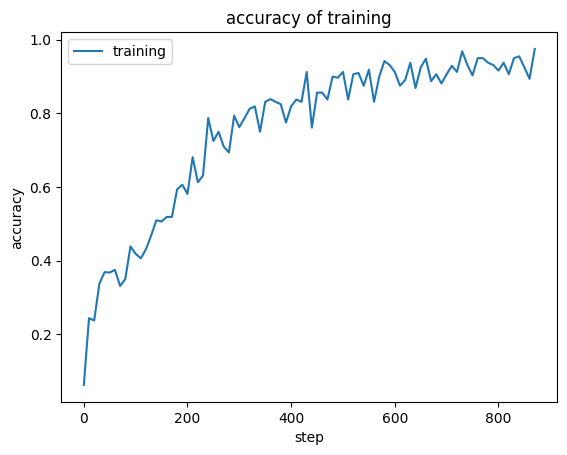

In [8]:
# 4.可视化
plt.plot(x_step, y_accuracy, label="training")
plt.xlabel("step")
plt.ylabel("accuracy")
plt.title("accuracy of training")
plt.legend()
plt.show()